## Linear mappings and matrices

In [9]:
# the required imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from skimage.transform import radon, rescale
from ipywidgets import interactive
import ipywidgets as widgets

# set print options
np.set_printoptions(precision=2)

_setup some helper functions_

In [2]:
# define rotation matrix by angle (in degrees)

def getRotationMatrix(angleInDegrees):
    angle = np.deg2rad(angleInDegrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    return R

def drawVectorsInCoordSystem(axes, vector1, vector2):
    # setup coordinate system
    axes.set_xlim(-1, 1); axes.set_ylim(-1, 1);
    axes.spines['right'].set_visible(False); axes.spines['top'].set_visible(False)
    axes.spines['left'].set_position('center'); axes.spines['bottom'].set_position('center')
    axes.xaxis.set_major_locator(ticker.MaxNLocator(2))
    axes.yaxis.set_major_locator(ticker.MaxNLocator(2))

    # draw vectors as arrows
    axes.arrow(0, 0, vector1[0], vector1[1], head_width=0.05, head_length=0.1, color='b')
    axes.arrow(0, 0, vector2[0], vector2[1], head_width=0.05, head_length=0.1, color='r')


### Rotating a vector

In [8]:
# visualize rotation by matrix R
def rotate(phi):
    vector = np.array([0.5, 0.5]) # original vector
    R = getRotationMatrix(phi)    # the rotation matrix R
    rotatedVector = R.dot(vector) # rotate the vector by applying matrix R

    print(R)
    plt.figure(figsize=(5,5))
    drawVectorsInCoordSystem(plt.axes(), vector, rotatedVector)
    plt.show()

iplot = interactive(rotate, phi=widgets.IntSlider(min=0, max=360, step=1, value=45, continuous_update=False))
output = iplot.children[-1]; 
output.layout.height = '350px' # make it flicker less
iplot

interactive(children=(IntSlider(value=45, continuous_update=False, description='phi', max=360), Output(layout=…

### Transforming images with linear mappings

In [4]:
# helper function to load Shepp-Logan phantom 

def getPhantom(size):
    if size == 128:
        return plt.imread('phantom.png')
    elif size == 4:
        p = plt.imread('phantom.png')
        return rescale(p, scale=1/32, mode='reflect', multichannel=False)
    else:
        raise NotImplementedError


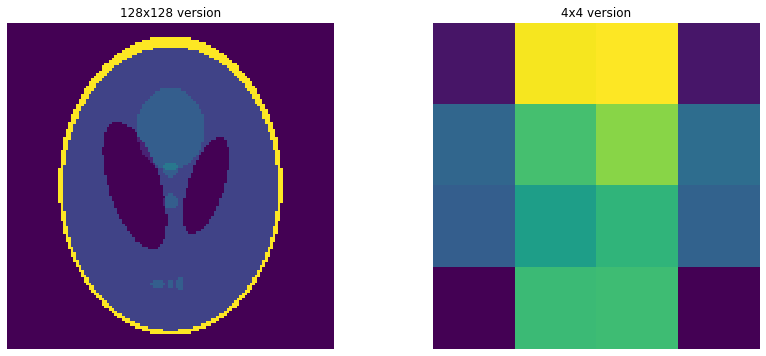

In [5]:
# show Shepp-Logan phantom in various sizes
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1, title='128x128 version')
plt.imshow( getPhantom(128) ); plt.axis('off')

plt.subplot(1, 2, 2, title='4x4 version')
plt.imshow( getPhantom(4) ); plt.axis('off')

plt.show()

### Fourier transform

In [6]:
# compute the 2d Fourier transform (real part) of an image

def get2dFFT(image):
    result = np.fft.fftshift(np.fft.fft2(image)) 
    return np.real(result) # return only the real part

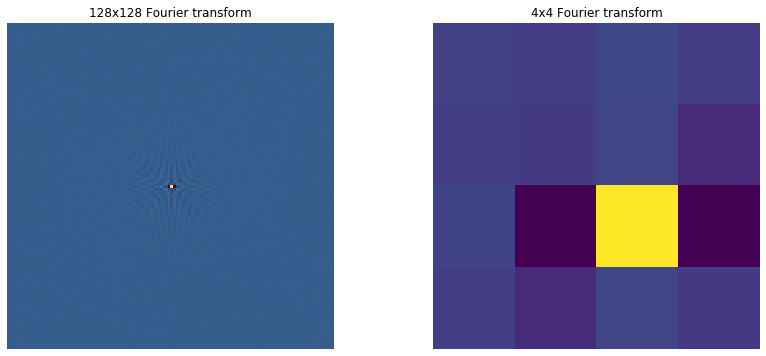

In [7]:
# visualize the 2d Fourier transform (real part) of the Shepp-Logan phantom
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1, title='128x128 Fourier transform')
plt.imshow(get2dFFT(getPhantom(128))); plt.axis('off')

plt.subplot(1, 2, 2, title='4x4 Fourier transform')
plt.imshow(get2dFFT(getPhantom(4))); plt.axis('off')

plt.show()

### Radon transform

In [8]:
# compute the 2d Radon transform
def radonTransform(numProjections):
    angles = np.linspace(0, 180, numProjections)
    transform = radon(getPhantom(128), angles, circle=True)
    
    plt.figure(figsize=(7,6))
    plt.title('Sinogram'); plt.xlabel('Projection angle'); plt.ylabel('Pixels')
    plt.imshow(transform)
    plt.show()

iplot2 = interactive(radonTransform, numProjections=widgets.IntSlider(min=1, max=180, value=90, continuous_update=False))
iplot2

interactive(children=(IntSlider(value=90, continuous_update=False, description='numProjections', max=180, min=…

### Compute the Fourier transform as a matrix

In [10]:
# compute the matrix of the Fourier transform

def computeFtMatrix(image):
    sizeX, sizeY = image.shape
    size = image.size
    
    M = np.zeros((size, size)) # initialize matrix with zeros
    basisVec = np.zeros(size)  # initialize basis vector with zeros
    
    for i in range(size):
        basisVec[i] = 1                            # set to i-th basis vector
        bVecAsImg = basisVec.reshape(sizeX, sizeY) # reshape to a 2d image
        
        column = get2dFFT(bVecAsImg)               # get 2d FFT of this basis vector
        M[:, i] = column.flatten()                 # linearize and put into matrix as i-th column
        
        basisVec[i] = 0                            # reset basis vector to zero
        
    return M

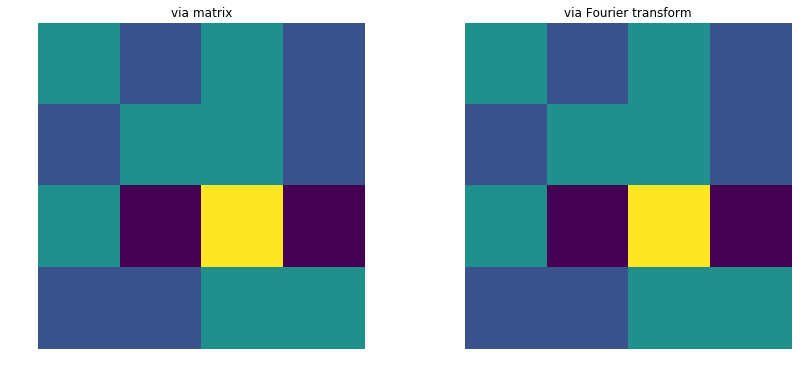

In [11]:
# compute transformation matrix M
phantomSmall = getPhantom(4)

# apply the Fourier transform matrix
M = computeFtMatrix(phantomSmall)
size = phantomSmall.shape                       # save size
resultMatrix = M.dot(phantomSmall.flatten())    # apply matrix M to linearized vector
resultMatrix = resultMatrix.reshape(size)       # un-linearize the image

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1, title='via matrix')
plt.imshow(resultMatrix); plt.axis('off')

plt.subplot(1, 2, 2, title='via Fourier transform')
plt.imshow(get2dFFT(phantomSmall)); plt.axis('off')
plt.show()